<a href="https://colab.research.google.com/github/SNCA-24/LunarLander_v3_Benchmarking_DQN_vs_PPO/blob/main/LunarLander_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load data and transform data(if neeeded)


In [1]:
#Cell 0
!pip install Box2D
!pip install stable_baselines3
!pip install 'shimmy>=2.0'
!pip install pygame
!pip install moviePy
!pip install --upgrade stable-baselines3 gymnasium

In [2]:
# Cell 1: Imports
import os
import random
import time
import datetime
import math
import uuid
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import moviepy
try:
    import gymnasium as gym
    print(f"Gymnasium version: {gym.__version__}")
except ImportError:
    print("⚠ Error: 'gymnasium' package is not installed. Install it using: !pip install gymnasium")
    raise ImportError("Gymnasium is required for this notebook.")
from gymnasium.wrappers import RecordVideo
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecVideoRecorder
# Verify Stable Baselines3
print(f"Stable Baselines3 version: {PPO.__module__.split('.')[0]}")


Gymnasium version: 1.1.1
Stable Baselines3 version: stable_baselines3


In [3]:
# Cell 2: Configuration & Hyperparameters
ENV_NAME = "LunarLander-v3"
# Reproducibility
SEEDS = [0, 1, 2]
def set_global_seed(seed: int):
    """Set seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Training schedule
EPISODES = 500
MILESTONES = [100,200,300,400,500]

# steps
TRAIN_MAX_STEPS = 1000
EVAL_MAX_STEPS = 500

# Replay buffer and optimization
BATCH_SIZE = 64
BUFFER_SIZE = 50_000

# Epsilon-greedy schedule
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 1e-4


# Discount factor and target update
GAMMA = 0.99
TARGET_UPDATE_FREQ = 1_000

# Algorithm-specific configurations
CONFIG = {
    'vanilla_dqn': {'lr': 1e-3, 'batch_size': 64, 'prioritized': False},
    'double_dqn': {'lr': 1e-3, 'batch_size': 64, 'prioritized': False},
    'dueling_dqn': {'lr': 1e-3, 'batch_size': 64, 'prioritized': False},
    'per_dqn': {'lr': 1e-3, 'batch_size': 64, 'prioritized': True, 'alpha': 0.6, 'beta': 0.4},
    'ppo': {'n_steps': 1000, 'learning_rate': 3e-4, 'batch_size' : 50}
}
# Directories
BASE_LOG_DIR = "logs"
BASE_VIDEO_DIR = "videos"
PLOTS_DIR = "plots"
os.makedirs(BASE_LOG_DIR, exist_ok=True)
os.makedirs(BASE_VIDEO_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

In [4]:
import shutil
shutil.rmtree(BASE_LOG_DIR, ignore_errors=True)
os.makedirs(BASE_LOG_DIR, exist_ok=True)

#Proposed Models

In [5]:
# Cell 3: Replay Buffer
from collections import namedtuple

Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayBuffer:
    def __init__(self, capacity: int, prioritized: bool = False, alpha: float = 0.6, beta: float = 0.4):
        self.capacity     = capacity
        self.prioritized  = prioritized
        self.alpha        = alpha
        self.beta         = beta
        self.buffer       = []
        self.priorities   = []
        self.position     = 0

    def push(self, *args):
        """Save a transition."""
        if len(self.buffer) < self.capacity:
            self.buffer.append(Transition(*args))
            self.priorities.append(max(self.priorities, default=1.0))
        else:
            self.buffer[self.position]     = Transition(*args)
            self.priorities[self.position] = max(self.priorities)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size: int):
        """
        Sample a batch of transitions, with optional prioritized replay.
        Returns: (transitions, indices, weights)
        """
        if self.prioritized and len(self.buffer) >= batch_size:
            # compute sampling probabilities
            probs = np.array(self.priorities, dtype=np.float32) ** self.alpha
            probs /= probs.sum()
            indices = np.random.choice(len(self.buffer), batch_size, p=probs)
            weights = (len(self.buffer) * probs[indices]) ** (-self.beta)
            weights /= weights.max()
            samples = [self.buffer[i] for i in indices]
            return samples, indices, torch.tensor(weights, dtype=torch.float32)
        else:
            samples = random.sample(self.buffer, batch_size)
            return samples, None, None

    def update_priorities(self, indices, errors):
        """Update priorities of sampled transitions."""
        for idx, err in zip(indices, errors):
            self.priorities[idx] = abs(err) + 1e-6

    def __len__(self):
        return len(self.buffer)

In [6]:
# Cell 4: Q-Networks
class QNetwork(nn.Module):
    def __init__(self, state_dim: int, action_dim: int, hidden_dim: int = 128):
        super(QNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

class DuelingQNetwork(nn.Module):
    def __init__(self, state_dim: int, action_dim: int, hidden_dim: int = 128):
        super(DuelingQNetwork, self).__init__()
        # value stream
        self.value_net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        # advantage stream
        self.adv_net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        value = self.value_net(x)
        adv   = self.adv_net(x)
        # broadcast value and normalize advantage
        return value + (adv - adv.mean(dim=1, keepdim=True))

In [7]:
# Cell 5: DQN Agent Base
class DQNAgent:
    def __init__(self, state_dim: int, action_dim: int, variant: str, config: dict):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.variant = variant
        self.config = config
        # Verify dimensions
        assert state_dim == 8, f"Expected state_dim=8, got {state_dim}"
        assert action_dim == 4, f"Expected action_dim=4, got {action_dim}"
        # Choose network architecture
        if variant == "dueling":
            self.q_net = DuelingQNetwork(state_dim, action_dim)
            self.target_net = DuelingQNetwork(state_dim, action_dim)
        else:
            self.q_net = QNetwork(state_dim, action_dim)
            self.target_net = QNetwork(state_dim, action_dim)
        self.target_net.load_state_dict(self.q_net.state_dict())
        # Replay buffer
        prioritized = config.get('prioritized', False)
        alpha = config.get('alpha', 0.6)
        beta = config.get('beta', 0.4)
        self.buffer = ReplayBuffer(BUFFER_SIZE, prioritized=prioritized, alpha=alpha, beta=beta)
        # Optimizer
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=config['lr'])
        # Counters
        self.steps_done = 0

    def select_action(self, state):
        # Epsilon-greedy
        eps = EPS_END + (EPS_START - EPS_END) * math.exp(-self.steps_done * EPS_DECAY)
        self.steps_done += 1
        if random.random() < eps:
            return random.randrange(self.action_dim)
        state_t = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            return int(self.q_net(state_t).argmax(dim=1).item())

    def store_transition(self, state, action, reward, next_state, done):
        self.buffer.push(state, action, reward, next_state, done)

    def train_step(self):
        # ————————————
        # Beta annealing for PER‑DQN:
        # linearly increase buffer.beta from 0.4 → 1.0 over 500 000 steps
        if self.variant == "per":
            self.buffer.beta = min(1.0, 0.4 + (1.0 - 0.4) * (self.steps_done / 500_000))
        # ————————————
        if len(self.buffer) < self.config['batch_size']:
            return None
        transitions, indices, weights = self.buffer.sample(self.config['batch_size'])
        states, actions, rewards, next_states, dones = zip(*transitions)
        s_v = torch.tensor(np.stack(states), dtype=torch.float32)
        a_v = torch.tensor(actions, dtype=torch.int64).unsqueeze(-1)
        r_v = torch.tensor(rewards, dtype=torch.float32).unsqueeze(-1)
        ns_v = torch.tensor(np.stack(next_states), dtype=torch.float32)
        d_v = torch.tensor(dones, dtype=torch.float32).unsqueeze(-1)
        q_current = self.q_net(s_v).gather(1, a_v)
        with torch.no_grad():
            if self.variant == "double":
                next_actions = self.q_net(ns_v).argmax(dim=1, keepdim=True)
                q_next = self.target_net(ns_v).gather(1, next_actions)
            else:
                q_next = self.target_net(ns_v).max(1, keepdim=True)[0]
            q_target = r_v + GAMMA * (1 - d_v) * q_next
        if self.buffer.prioritized and indices is not None:
            errors = (q_current - q_target).squeeze().abs().detach().cpu().numpy()
            self.buffer.update_priorities(indices, errors)
            loss = ((q_current - q_target).pow(2) * weights.unsqueeze(1)).mean()
        else:
            loss = F.mse_loss(q_current, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        # Periodic target update
        if self.steps_done % TARGET_UPDATE_FREQ == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())
        return loss.item()

In [8]:
# Cell 6: Vanilla DQN Factory
def make_vanilla_dqn_agent(env=None):
    """Instantiate a Vanilla DQN agent."""
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    assert state_dim == 8, f"Expected state_dim=8, got {state_dim}"
    assert action_dim == 4, f"Expected action_dim=4, got {action_dim}"
    return DQNAgent(state_dim, action_dim, variant="vanilla", config=CONFIG['vanilla_dqn'])

In [9]:
# Cell 7: Double DQN Factory
def make_double_dqn_agent(env=None):
    """Instantiate a Double DQN agent."""
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    assert state_dim == 8, f"Expected state_dim=8, got {state_dim}"
    assert action_dim == 4, f"Expected action_dim=4, got {action_dim}"
    return DQNAgent(state_dim, action_dim, variant="double", config=CONFIG['double_dqn'])

In [10]:
# Cell 8: Dueling DQN Factory
def make_dueling_dqn_agent(env=None):
    """Instantiate a Dueling DQN agent."""
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    assert state_dim == 8, f"Expected state_dim=8, got {state_dim}"
    assert action_dim == 4, f"Expected action_dim=4, got {action_dim}"
    return DQNAgent(state_dim, action_dim, variant="dueling", config=CONFIG['dueling_dqn'])

In [11]:
# Cell 9: PER DQN Factory

def make_per_dqn_agent(env=None):
    """Instantiate a Prioritized Experience Replay DQN agent."""
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    assert state_dim == 8, f"Expected state_dim=8, got {state_dim}"
    assert action_dim == 4, f"Expected action_dim=4, got {action_dim}"
    return DQNAgent(state_dim, action_dim, variant="per", config=CONFIG['per_dqn'])

# Baseline model - PPO


In [12]:
# Cell 10: PPO Agent Factory - legacy (monitor)

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor


def make_ppo_agent(seed: int, monitor_log_dir: str):
    """
    Instantiate a PPOAgentWrapper whose VecEnv uses Monitor to log
    episode reward, length and fuel (via info_keywords).
    monitor_log_dir must be a real directory path.
    """
    # sanity check
    if monitor_log_dir is None:
        raise ValueError("make_ppo_agent requires a non-None monitor_log_dir")
    os.makedirs(monitor_log_dir, exist_ok=True)

    def _make_env():
        # build your wrapped env once
        env = make_env(seed=seed)
        return Monitor(
            env,
            filename=os.path.join(monitor_log_dir, "monitor.csv"),
            info_keywords=("fuel",),
        )

    vec_env = DummyVecEnv([_make_env])
    model = PPO(
        "MlpPolicy",
        vec_env,
        verbose=0,
        n_steps=CONFIG["ppo"]["n_steps"],
        batch_size=CONFIG["ppo"].get("batch_size", 64),
        learning_rate=CONFIG["ppo"]["learning_rate"],
        seed=seed,
    )
    return PPOAgentWrapper(model, vec_env)



class PPOAgentWrapper:
    def __init__(self, model, vec_env):
        self.model = model
        self.vec_env = vec_env

    def learn(self, total_timesteps: int, reset_num_timesteps: bool = False, callback = None, **kwargs):
        """Train the model, forwarding any callback(s) to SB3."""
        return self.model.learn(
            total_timesteps=total_timesteps,
            reset_num_timesteps=reset_num_timesteps,
            callback=callback,
            **kwargs
        )

    def predict(self, state, deterministic=True):
        state_vec = np.array(state, dtype=np.float32)[None]
        action, _ = self.model.predict(state_vec, deterministic=deterministic)
        return int(action[0]), _

In [13]:
# Cell 11: Environment Factory
class FuelTrackingWrapper(gym.Wrapper):
    """Wrapper to track fuel consumption based on actions."""
    def __init__(self, env):
        super().__init__(env)
        self.initial_fuel = 1000.0  # Initial fuel for remaining fuel metric
        self.fuel = 0.0
        # Fuel costs: main engine (-0.3), side engines (-0.03)
        self.fuel_costs = {0: 0.0, 1: -0.03, 2: -0.3, 3: -0.03}  # Actions: none, left, main, right

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        self.fuel += self.fuel_costs[action]
        info['fuel'] = self.initial_fuel + self.fuel  # Remaining fuel
        return obs, reward, terminated, truncated, info

    def reset(self, **kwargs):
        self.fuel = 0.0
        obs, info = self.env.reset(**kwargs)
        info['fuel'] = self.initial_fuel
        return obs, info

def make_env(seed=None, record=False, record_path=None, video_prefix=None):
    env = gymnasium.make(ENV_NAME, render_mode="rgb_array")
    # Verify state and action spaces
    assert env.observation_space.shape[0] == 8, f"Expected state_dim=8, got {env.observation_space.shape[0]}"
    assert env.action_space.n == 4, f"Expected action_dim=4, got {env.action_space.n}"
    # Wrap with fuel tracking
    env = FuelTrackingWrapper(env)
    if seed is not None:
        env.reset(seed=seed)
    if record and record_path:
        # ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S_%f")
        prefix = video_prefix or f"{ENV_NAME}"
        env = RecordVideo(env, video_folder=record_path, name_prefix=prefix, episode_trigger=lambda x: x in MILESTONES)
    return env

#Evaluate models


In [14]:
# Cell 12: Evaluation Utility (Updated)

def evaluate(agent, is_ppo, episodes=10, record=False, record_path=None, video_prefix=None,return_raw=False, eval_seed: int = None):
    stats = {"reward": [], "success": [], "dist": [], "fuel": []}


    # ─── Build & wrap the env ONE TIME ───
    if is_ppo:
        # start from the agent’s VecEnv
        base_env = agent.vec_env
        if record and record_path and video_prefix:
            env = VecVideoRecorder(
                base_env,
                video_folder=record_path,
                record_video_trigger=lambda step: step == 0,
                video_length=EVAL_MAX_STEPS,
                name_prefix=video_prefix,
            )
        else:
            env = base_env
    else:
        # single‐env for DQN
        base_env = make_env(
            seed=eval_seed,
            record=record,
            record_path=record_path,
            video_prefix=video_prefix,
        )
        if record and record_path and video_prefix:
            env = RecordVideo(
                base_env,
                video_folder=record_path,
                name_prefix=video_prefix,
            )
        else:
            env = base_env

    # ─── Run N episodes ───
    for ep in range(episodes):
        # reseed if requested
        if eval_seed is not None and is_ppo:
            # VecEnv supports .seed()
            env.seed(eval_seed)

        # reset
        if is_ppo:
            obs = env.reset()       # no seed arg on VecEnv
            state = obs[0]
        else:
            state, _ = env.reset(seed=eval_seed)

        total_r, total_f = 0.0, 0.0
        done = False

        for t in range(EVAL_MAX_STEPS):
            if is_ppo:
                action, _ = agent.predict(state)
                obs, rewards, dones, infos = env.step([action])
                ns, r, done, info = obs[0], rewards[0], dones[0], infos[0]
            else:
                action = agent.select_action(state)
                ns, r, term, trunc, info = env.step(action)
                done = term or trunc

            total_r += r
            total_f   = info.get("fuel", 0)
            state     = ns

            if done:
                stats["success"].append(1 if total_r >= 200 else 0)
                stats["dist"].append(math.hypot(state[0], state[1]))
                break

        if not done:
            stats["success"].append(0)
            stats["dist"].append(math.hypot(state[0], state[1]))

        stats["reward"].append(total_r)
        stats["fuel"].append(total_f)

    # ─── Clean up ───
    if record:
        env.close()
    if not is_ppo:
        base_env.close()

    if return_raw:
        return stats["reward"]

    mean_r, std_r = np.mean(stats["reward"]), np.std(stats["reward"])
    mean_d, std_d = np.mean(stats["dist"]),   np.std(stats["dist"])
    return {
        "mean_reward":  f"{mean_r:.2f} ± {std_r:.2f}",
        "success_rate": np.mean(stats["success"]),
        "mean_dist":    f"{mean_d:.2f} ± {std_d:.2f}",
        "mean_fuel":    np.mean(stats["fuel"]),
        "std_reward":   std_r,
        "std_dist":     std_d,
    }

#Train Models


In [15]:
# Cell 13: Training & Milestone Logging
import time
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.vec_env import VecVideoRecorder



def train_and_snapshot(name, agent_ctor, is_ppo):
    """Train an agent, log per-episode metrics, checkpoints, and milestone evaluations."""
    # Master log for full training
    master_full_log = os.path.join(BASE_LOG_DIR, "master_full_training.csv")
    master_milestone_log = os.path.join(BASE_LOG_DIR, "master_milestone_metrics.csv")

    if not os.path.exists(master_full_log):
      # create empty CSV with only column headers
      pd.DataFrame(
          columns=[
              "algorithm","seed","episode","reward",
              "steps","time_sec","fuel",
              "sample_efficiency","training_std"
            ]).to_csv(master_full_log, index=False)

    if not os.path.exists(master_milestone_log):
      # create empty CSV with only column headers
      pd.DataFrame(
          columns=[
              "algorithm","seed","episode","mean_reward",
              "success_rate","mean_dist","mean_fuel",
              "sample_efficiency","training_std", "eval_variance",
              "time_sec","gpu_bytes"
          ]).to_csv(master_milestone_log, index=False)

    # Directory for milestone videos
    tl_base = os.path.join(BASE_VIDEO_DIR, "timeline_comparisons")
    os.makedirs(tl_base, exist_ok=True)
    for m in MILESTONES:
        os.makedirs(os.path.join(tl_base, f"milestone_{m}_eps"), exist_ok=True)

    total_steps = 0
    gpu_timer = GPUTimer()
    for seed in SEEDS:
        set_global_seed(seed)
        if is_ppo:
            # 1) wrap PPO’s VecEnv in a VecMonitor that writes monitor.csv
            seed_dir = os.path.join(BASE_LOG_DIR, name, f"seed{seed}")
            agent    = agent_ctor(seed=seed, monitor_log_dir=seed_dir)
        else:
            env = make_env(seed)
            agent = agent_ctor(env)

        log_dir = os.path.join(BASE_LOG_DIR, name)
        os.makedirs(log_dir, exist_ok=True)

        episode_rewards = []
        first_success_steps = float('inf')

        for epi in range(1, EPISODES + 1):
            start = time.time()
            if is_ppo:

                # 2) do one “episode” worth of TRAIN_MAX_STEPS
                agent.learn(
                    total_timesteps=TRAIN_MAX_STEPS,
                    reset_num_timesteps=False
                )
                # ── force a reset so Monitor writes the final row ──
                agent.vec_env.reset()

                mon = pd.read_csv(
                    os.path.join(seed_dir, "monitor.csv"),
                    comment='#'   # skip the header comment line
                )

                # 3.1) figure out which column holds the episode reward
                for c in ("r", "episode_reward", "reward"):
                    if c in mon.columns:
                        reward_col = c
                        break
                else:
                    raise KeyError(f"No reward column found in monitor.csv; got {mon.columns.tolist()}")

                ep_reward = mon[reward_col].iloc[-1]

                # 3.2) figure out which column holds the episode length
                for c in ("l", "episode_length", "length"):
                    if c in mon.columns:
                        length_col = c
                        break
                else:
                    # fallback if nothing matches
                    length_col = None

                if length_col:
                    steps = int(mon[length_col].iloc[-1])
                else:
                    steps = TRAIN_MAX_STEPS

                # 3.3) pull out the info dict so we can extract fuel

                def _safe_float(x):
                    """Return float(x) or 0.0 on failure."""
                    try:
                        return float(x)
                    except Exception:
                        return 0.0

                if "fuel" in mon.columns:
                    # monitor wrote a dedicated 'fuel' column → easiest case
                    ep_fuel = _safe_float(mon["fuel"].iloc[-1])

                elif "infos" in mon.columns:          # older Monitor versions
                    # each entry is a dict-string like "{'fuel': 987.0, ...}"
                    ep_fuel = _safe_float(eval(mon["infos"].iloc[-1]).get("fuel", 0))

                elif "info" in mon.columns:           # very old Monitor
                    ep_fuel = _safe_float(eval(mon["info"].iloc[-1]).get("fuel", 0))

                else:
                    ep_fuel = 0.0                     # fallback ─ shouldn’t normally happen

                total_steps += steps


            else:
                state, _ = env.reset()
                ep_reward = 0
                for t in range(TRAIN_MAX_STEPS):
                    action = agent.select_action(state)
                    ns, r, term, trunc, info = env.step(action)
                    agent.store_transition(state, action, r, ns, term or trunc)
                    agent.train_step()
                    state = ns
                    ep_reward += r
                    total_steps += 1
                    if term or trunc:
                        break
                steps = t + 1
                ep_fuel = info['fuel']

            elapsed = time.time() - start
            episode_rewards.append(ep_reward)

            # Sample efficiency: steps to reach reward >= 200
            # sample_eff = total_steps if ep_reward >= 200 and total_steps > 0 else float('inf')
            if ep_reward >= 200 and first_success_steps == float('inf'):
                first_success_steps = total_steps
            sample_eff = first_success_steps if first_success_steps < float('inf') else float('inf')

            # Training stability: standard deviation of last 50 episodes
            # reward_var = np.var(episode_rewards[-10:]) if len(episode_rewards) >= 10 else 0.0
            training_std = float(np.std(episode_rewards[-50:])) if len(episode_rewards) >= 50 else float(np.std(episode_rewards))

            # Append to master log
            pd.DataFrame([{
                "algorithm": name,
                "seed": seed,
                "episode": epi,
                "reward": ep_reward,
                "steps": steps,
                "time_sec": elapsed,
                "fuel": ep_fuel,
                "sample_efficiency": sample_eff,
                "training_std": training_std
            }]).to_csv(master_full_log, mode="a", header=False, index=False)

            # Checkpoint DQN
            if not is_ppo and epi == EPISODES:
                ckpt = os.path.join(log_dir, f"{name}_seed{seed}_final.pth")
                torch.save(agent.q_net.state_dict(), ckpt)

            # ── SAVE THE TRAINED MODEL ──
            if epi == EPISODES:
                if is_ppo:
                    # save the SB3 PPO model
                    agent.model.save(os.path.join(log_dir, f"{name}_seed{seed}_model.zip"))
                else:
                    # save the DQN weights
                    torch.save(
                        agent.q_net.state_dict(),
                        os.path.join(log_dir, f"{name}_seed{seed}_qnet.pth")
                    )


            if epi in MILESTONES:
              vid_dir = os.path.join(tl_base, f"milestone_{epi}_eps", f"seed{seed}")
              os.makedirs(vid_dir, exist_ok=True)

              # ── time everything that follows ───────────────────────────────
              with gpu_timer.track():

                  # 1) First get your usual metrics (no video) over 10 episodes
                  metrics = evaluate(agent, is_ppo, episodes=10)

                  # 2) If PPO, spin up a brand‐new env just for the one video pass
                  if is_ppo:
                      def _make_rec_env():
                          e = make_env(seed=seed)
                          return RecordVideo(
                              e,
                              video_folder=vid_dir,
                              name_prefix=f"{name}_milestone_{epi}_seed{seed}",
                              episode_trigger=lambda ep: ep == 0 # Only record the first episode

                          )
                      rec_env = DummyVecEnv([_make_rec_env])
                      obs = rec_env.reset()
                      for t in range(EVAL_MAX_STEPS):
                          action, _ = agent.predict(obs[0], deterministic=True)
                          obs, _, dones, _ = rec_env.step([action])
                          if dones[0]:
                              break

                      # Add a small delay to ensure video is fully written
                      time.sleep(1)  # Wait 1 second before closing
                      rec_env.close()
                  else:
                      # DQN: existing single-env record
                      _ = evaluate(
                          agent,
                          is_ppo,
                          episodes=1,
                          record=True,
                          record_path=vid_dir,
                          video_prefix=f"{name}_milestone_{epi}_seed{seed}"
                      )

                  # 3) finally compute evaluation‐variance over 10 raw rewards
                  raw_rewards = evaluate(
                      agent,
                      is_ppo,
                      episodes=10,
                      return_raw=True,
                      eval_seed=seed
                  )
                  eval_variance = float(np.var(raw_rewards))

              # 4) record GPU stats & append to CSV as before
              gpu_stats = gpu_timer.summary()
              pd.DataFrame([{
                  "algorithm": name,
                  "seed": seed,
                  "episode": epi,
                  "mean_reward": metrics["mean_reward"],
                  "success_rate": metrics["success_rate"],
                  "mean_dist": metrics["mean_dist"],
                  "mean_fuel": metrics["mean_fuel"],
                  "sample_efficiency": sample_eff,
                  "training_std": training_std,
                  "eval_variance": eval_variance,
                  "time_sec": gpu_stats["mean_time_sec"],
                  "gpu_bytes": gpu_stats["mean_peak_gpu_bytes"]
              }]).to_csv(master_milestone_log, mode="a", header=False, index=False)


    if not is_ppo:
          # close the single‐env you created for DQN
        env.close()

    return agent

In [16]:
# Cell 14: GPU Memory Tracking Utility
import contextlib

class GPUTimer:
    """Context manager to track CUDA memory usage and runtime."""
    def __init__(self):
        self.peak_mem = []
        self.times = []

    @contextlib.contextmanager
    def track(self):
        """Track GPU memory and runtime for a code block."""
        t0 = time.time()
        if torch.cuda.is_available() and torch.cuda.device_count() > 0:
            torch.cuda.reset_peak_memory_stats()
        yield
        t1 = time.time()
        self.times.append(t1 - t0)
        # Record peak memory if available, else 0
        if torch.cuda.is_available() and torch.cuda.device_count() > 0:
            self.peak_mem.append(torch.cuda.max_memory_allocated())
        else:
            self.peak_mem.append(0)

    def summary(self):
        """Return mean time and peak GPU memory usage."""
        return {
            'mean_time_sec': np.mean(self.times) if self.times else 0,
            'mean_peak_gpu_bytes': np.mean(self.peak_mem) if self.peak_mem else 0
        }

In [17]:
# Cell 15: Orchestrator
import gymnasium

gpu_timer = GPUTimer()
trained_agents = []

agents = [
    {"name": "Vanilla_DQN", "factory": make_vanilla_dqn_agent, "is_ppo": False},
    {"name": "Double_DQN",  "factory": make_double_dqn_agent,  "is_ppo": False},
    {"name": "Dueling_DQN", "factory": make_dueling_dqn_agent, "is_ppo": False},
    {"name": "PER_DQN",     "factory": make_per_dqn_agent,     "is_ppo": False},
    {"name": "PPO",         "factory": make_ppo_agent,         "is_ppo": True},
]

# Train each agent with GPU monitoring
for agent_info in agents:
    name = agent_info["name"]
    factory = agent_info["factory"]
    is_ppo = agent_info["is_ppo"]
    seed = 0
    print(f"Starting training for {name}...")

    try:
        if is_ppo:
            # let the PPO factory build its own seeded VecEnv
            # agent = factory(seed=0)
            # build a per‐seed log directory and pass it in
            seed_dir = os.path.join(BASE_LOG_DIR, name, f"seed{seed}")
            os.makedirs(seed_dir, exist_ok=True)
            agent = factory(seed=seed, monitor_log_dir=seed_dir)
        else:
            env   = make_env(seed=seed)
            agent = factory(env)

        with gpu_timer.track():
          agent = train_and_snapshot(name, factory, is_ppo=is_ppo)

        gpu_summary = gpu_timer.summary()
        print(f"{name} GPU Summary: {gpu_summary}")

        # — Post‐training 10‐episode evaluation —
        post_train_metrics = evaluate(agent, is_ppo, episodes=10, eval_seed=0)
        print(f"{name} Post Training → mean_reward: {post_train_metrics['mean_reward']}, "
        f"success_rate: {post_train_metrics['success_rate']:.2f}, "
        f"mean_dist: {post_train_metrics['mean_dist']}")

        # close DQN eval env
        if not is_ppo:
            env.close()

        # stash for later visualization
        trained_agents.append({
            "name": name,
            "agent": agent,
            "is_ppo": is_ppo
        })


    except Exception as e:
        print(f"⚠ Training failed for {name}: {e}")
        continue
print("✅ Training completed for all agents.")


Starting training for Vanilla_DQN...


/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/videos/timeline_comparisons/milestone_100_eps/seed0 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/videos/timeline_comparisons/milestone_200_eps/seed0 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/videos/timeline_comparisons/milestone_300_eps/seed0 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: Us

Vanilla_DQN GPU Summary: {'mean_time_sec': np.float64(1487.9626669883728), 'mean_peak_gpu_bytes': np.float64(0.0)}
Vanilla_DQN Post Training → mean_reward: 285.36 ± 1.04, success_rate: 1.00, mean_dist: 0.18 ± 0.01
Starting training for Double_DQN...
Double_DQN GPU Summary: {'mean_time_sec': np.float64(1503.0263875722885), 'mean_peak_gpu_bytes': np.float64(0.0)}
Double_DQN Post Training → mean_reward: 286.61 ± 4.51, success_rate: 1.00, mean_dist: 0.08 ± 0.03
Starting training for Dueling_DQN...
Dueling_DQN GPU Summary: {'mean_time_sec': np.float64(1684.5809121926625), 'mean_peak_gpu_bytes': np.float64(0.0)}
Dueling_DQN Post Training → mean_reward: 238.86 ± 32.79, success_rate: 0.90, mean_dist: 0.26 ± 0.03
Starting training for PER_DQN...
PER_DQN GPU Summary: {'mean_time_sec': np.float64(1515.9850752353668), 'mean_peak_gpu_bytes': np.float64(0.0)}
PER_DQN Post Training → mean_reward: 12.05 ± 17.59, success_rate: 0.00, mean_dist: 0.22 ± 0.01
Starting training for PPO...


/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/videos/timeline_comparisons/milestone_100_eps/seed0 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/videos/timeline_comparisons/milestone_200_eps/seed0 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/videos/timeline_comparisons/milestone_300_eps/seed0 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: Us

PPO GPU Summary: {'mean_time_sec': np.float64(1734.5589341640473), 'mean_peak_gpu_bytes': np.float64(0.0)}
PPO Post Training → mean_reward: -77.38 ± 0.00, success_rate: 0.00, mean_dist: 1.41 ± 0.00
✅ Training completed for all agents.


#Visualize Results


In [18]:
# Cell 16: Export trajectories, angular velocities & Q-values to CSV
import pandas as pd

traj_rows = []
ang_rows  = []
q_rows    = []

for info in trained_agents:
    name, agent, is_ppo = info["name"], info["agent"], info["is_ppo"]
    seed = 0

    # ─── Collect one rollout for trajectory ───
    env = make_env(seed=seed)
    state, _ = env.reset(seed=seed)
    steps = 0
    while steps < TRAIN_MAX_STEPS:
        # record position
        traj_rows.append({
            "algorithm": name,
            "seed": seed,
            "step": steps,
            "x": state[0],
            "y": state[1]
        })
        # pick action
        if is_ppo:
            action, _ = agent.predict(state, deterministic=True)
        else:
            with torch.no_grad():
                st_t = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                action = int(agent.q_net(st_t).argmax(dim=1).item())
        # step
        state, _, term, trunc, _ = env.step(action)
        steps += 1
        if term or trunc:
            break
    env.close()

    # ─── Collect visited states for ang‐vel & Q‐value ───
    env = make_env(seed=seed)
    state, _ = env.reset(seed=seed)
    samples = 1000
    for i in range(samples):
        # angular velocity
        ang_rows.append({
            "algorithm": name,
            "seed": seed,
            "angular_velocity": float(state[4])
        })
        # Q‐values (only for DQN variants)
        if not is_ppo:
            with torch.no_grad():
                qv = agent.q_net(torch.tensor(state[None], dtype=torch.float32))
            for qval in qv.cpu().numpy().flatten().tolist():
                q_rows.append({
                    "algorithm": name,
                    "seed": seed,
                    "q_value": float(qval)
                })
        # take a random step (or your policy)
        if is_ppo:
            action, _ = agent.predict(state, deterministic=True)
        else:
            action = agent.select_action(state)
        state, _, term, trunc, _ = env.step(action)
        if term or trunc:
            state, _ = env.reset(seed=seed)
    env.close()

# write CSVs
pd.DataFrame(traj_rows).to_csv(os.path.join(BASE_LOG_DIR, "trajectories.csv"), index=False)
pd.DataFrame(ang_rows ).to_csv(os.path.join(BASE_LOG_DIR, "angular_velocities.csv"), index=False)
pd.DataFrame(q_rows   ).to_csv(os.path.join(BASE_LOG_DIR, "q_values.csv"), index=False)

In [19]:
# Cell 17: Tear down any remaining PPO VecEnvs
for info in trained_agents:
    if info["is_ppo"]:
        info["agent"].vec_env.close()

In [20]:
# Cell 17: Utilities
def compute_sample_efficiency(log_df, reward_threshold=200):
    """Compute steps to reach a reward threshold for sample efficiency."""
    first_success = log_df[log_df['reward'] >= reward_threshold]['steps'].cumsum()
    return first_success.iloc[0] if not first_success.empty else float('inf')

def compute_training_stability(log_df, window=10):
    """Compute variance of rewards over the last N episodes."""
    if len(log_df) < window:
        return 0.0
    return np.var(log_df['reward'].tail(window))

def validate_log_file(file_path):
    """Validate CSV log file integrity."""
    try:
        df = pd.read_csv(file_path)
        required_cols = ['algorithm', 'seed', 'episode', 'reward']
        if not all(col in df.columns for col in required_cols):
            print(f"⚠ Missing required columns in {file_path}")
            return None
        if df.empty or df['reward'].isna().all():
            print(f"⚠ Empty or invalid data in {file_path}")
            return None
        return df
    except (pd.errors.ParserError, pd.errors.EmptyDataError):
        print(f"⚠ Corrupted or empty file: {file_path}")
        return None

In [21]:
# Cell 18: Post-Training Evaluation & Plots (v2)
import glob


# load a shared palette
PALETTE = {
    "Vanilla_DQN": "#1f77b4",
    "Double_DQN":  "#ff7f0e",
    "Dueling_DQN": "#2ca02c",
    "PER_DQN":     "#d62728",
    "PPO":         "#9467bd",
}

# ——— Full-training CSV ———
all_logs = glob.glob(os.path.join(BASE_LOG_DIR,"master_full_training.csv"))
if all_logs:
    df = pd.read_csv(all_logs[0])
    for c in ['episode','reward','fuel','time_sec','sample_efficiency','training_std']:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    df.dropna(subset=['episode','reward'], inplace=True)

# 1) Learning curve (unchanged)
    plt.figure(figsize=(10,6))
    for algo, grp in df.groupby("algorithm"):
        grp.groupby("episode")["reward"].mean().plot(
            color=PALETTE[algo], label=algo)
    plt.title("Mean Reward vs Episode")
    plt.xlabel("Episode"); plt.ylabel("Mean Reward")
    plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR,"learning_curve_by_algo.png"))

    plt.close()

# 2) Reward vs Fuel, split by algorithm
    plt.figure(figsize=(8,6))
    for algo, grp in df.groupby("algorithm"):
        plt.scatter(grp.reward, grp.fuel,
                    s=10, alpha=0.6, color=PALETTE[algo], label=algo)
    plt.title("Reward vs Remaining Fuel")
    plt.xlabel("Reward"); plt.ylabel("Fuel")
    plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR,"reward_vs_fuel_by_algo.png"))

    plt.close()

# 3) Reward vs Time, split by algorithm
    plt.figure(figsize=(8,6))
    for algo, grp in df.groupby("algorithm"):
        plt.scatter(grp.reward, grp.time_sec,
                    s=10, alpha=0.6, color=PALETTE[algo], label=algo)
    plt.title("Reward vs Time per Episode")
    plt.xlabel("Reward"); plt.ylabel("Time (s)")
    plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR,"reward_vs_time_by_algo.png"))

    plt.close()

# ——— Milestone metrics CSV ———
m_logs = glob.glob(os.path.join(BASE_LOG_DIR,"master_milestone_metrics.csv"))
if m_logs:
    dfm = pd.read_csv(m_logs[0])
    dfm = dfm[dfm.episode != 'episode'].copy().reset_index(drop=True)
    parts = dfm.mean_reward.astype(str).str.split(' ± ',expand=True)
    dfm['mean_reward'] = parts[0].astype(float)
    dfm['std_reward']  = parts[1].astype(float)
    for c in ['episode','mean_reward','std_reward','success_rate',
              'mean_fuel','sample_efficiency','training_std',
              'eval_variance','time_sec','gpu_bytes']:
        dfm[c] = pd.to_numeric(dfm[c], errors='coerce')
    dfm.dropna(subset=['episode','mean_reward'], inplace=True)

# 4) reward±std by milestone
    plt.figure(figsize=(10,6))
    for algo, grp in dfm.groupby("algorithm"):
        plt.errorbar(grp.episode, grp.mean_reward, yerr=grp.std_reward,
                     marker='o', capsize=3, color=PALETTE[algo], label=algo)
    plt.title("Mean Reward ± Std by Milestone")
    plt.xlabel("Episode"); plt.ylabel("Mean Reward")
    plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR,"milestones_reward_errorbar.png"))

    plt.close()

# 5) success‐rate trend
    plt.figure(figsize=(10,6))
    for algo, grp in dfm.groupby("algorithm"):
        plt.plot(grp.episode, grp.success_rate,
                 marker='o', linestyle='-',
                 color=PALETTE[algo], label=algo)
    plt.title("Success Rate by Milestone")
    plt.xlabel("Episode"); plt.ylabel("Success Rate")
    plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR,"milestones_success_rate.png"))

    plt.close()

# 6) sample efficiency (log y)
    plt.figure(figsize=(10,6))
    for algo, grp in dfm.groupby("algorithm"):
        plt.plot(grp.episode, grp.sample_efficiency,
                 marker='o', linestyle='-',
                 color=PALETTE[algo], label=algo)
    plt.yscale('log')
    plt.title("Sample Efficiency by Milestone (log scale)")
    plt.xlabel("Episode"); plt.ylabel("Steps to ≥200 (log)")
    plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR,"milestones_sample_efficiency_log.png"))

    plt.close()


# ——— Descent Trajectories CSV ———

# 7) Overlaid trajectories ───
    df_traj = pd.read_csv(os.path.join(BASE_LOG_DIR, "trajectories.csv"))
    plt.figure(figsize=(6,6))
    for algo, grp in df_traj.groupby("algorithm"):
        plt.plot(grp.x, grp.y, label=algo, color=PALETTE[algo], alpha=0.8)
    plt.title("Descent Trajectories Overlay")
    plt.xlabel("X position"); plt.ylabel("Y position")
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, "trajectory_overlay.png"))

    plt.close()

    # 8) 1×5 Trajectory grid ───
    fig, axes = plt.subplots(1, len(PALETTE), figsize=(4*len(PALETTE),4), sharex=True, sharey=True)
    for ax, (algo, grp) in zip(axes, df_traj.groupby("algorithm")):
        ax.plot(grp.x, grp.y, color=PALETTE[algo])
        ax.set_title(algo)
        ax.set_xlabel("X")
        if ax is axes[0]:
            ax.set_ylabel("Y")
        ax.grid(True)
    fig.suptitle("Individual Descent Trajectories")
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.savefig(os.path.join(PLOTS_DIR, "trajectory_grid.png"))

    plt.close()

# ——— Angular Velocities CSV ———

# 9) Angular velocity overlay ───
    df_ang = pd.read_csv(os.path.join(BASE_LOG_DIR, "angular_velocities.csv"))
    plt.figure(figsize=(8,6))
    for algo, grp in df_ang.groupby("algorithm"):
        plt.hist(grp.angular_velocity, bins=50, density=True,
                alpha=0.5, label=algo, color=PALETTE[algo])
    plt.title("Angular Velocity Distribution Overlay")
    plt.xlabel("Angular Velocity"); plt.ylabel("Density")
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, "angular_velocity_overlay.png"))

    plt.close()

# 10) 1×5 Angular‐velocity grid ───
    fig, axes = plt.subplots(1, len(PALETTE), figsize=(4*len(PALETTE),4), sharex=True, sharey=True)
    for ax, (algo, grp) in zip(axes, df_ang.groupby("algorithm")):
        ax.hist(grp.angular_velocity, bins=50, density=True, color=PALETTE[algo])
        ax.set_title(algo)
        ax.grid(True)
        if ax is axes[0]:
            ax.set_ylabel("Density")
        ax.set_xlabel("Angular Velocity")
    fig.suptitle("Angular Velocity by Algorithm")
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.savefig(os.path.join(PLOTS_DIR, "angular_velocity_grid.png"))

    plt.close()

# ——— Q-Values CSV ———
# 11) Q‐value overlay (only DQNs) ───
    df_q = pd.read_csv(os.path.join(BASE_LOG_DIR, "q_values.csv"))
    plt.figure(figsize=(8,6))
    for algo, grp in df_q.groupby("algorithm"):
        if algo == "PPO":
            continue
        plt.hist(grp.q_value, bins=50, density=True,
                alpha=0.5, label=algo, color=PALETTE[algo])
    plt.title("Q-Value Distribution Overlay")
    plt.xlabel("Q value"); plt.ylabel("Density")
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, "q_value_overlay.png"))

    plt.close()

# 12) 1×4 Q‐value grid ───
    dqn_algos = [a for a in PALETTE if a!="PPO"]
    fig, axes = plt.subplots(1, len(dqn_algos), figsize=(4*len(dqn_algos),4), sharex=True, sharey=True)
    for ax, algo in zip(axes, dqn_algos):
        grp = df_q[df_q.algorithm==algo]
        ax.hist(grp.q_value, bins=50, density=True, color=PALETTE[algo])
        ax.set_title(algo)
        ax.grid(True)
        if ax is axes[0]:
            ax.set_ylabel("Density")
        ax.set_xlabel("Q value")
    fig.suptitle("Q-Value by DQN Algorithm")
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.savefig(os.path.join(PLOTS_DIR, "q_value_grid.png"))

    plt.close()

# ——— Non-CSV ———
# 13) compute cost  (GPU memory removed)
fig, ax = plt.subplots(figsize=(6,5))          # ← one subplot only
cost = dfm.groupby("algorithm")["time_sec"].mean()

cost.plot(kind="bar",color=[PALETTE[a] for a in cost.index],ax=ax)
ax.set_title("Compute Time")
ax.set_ylabel("Seconds")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "compute_cost.png"))  # new filename

plt.close()

<ipython-input-22-7af97ff52134>:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


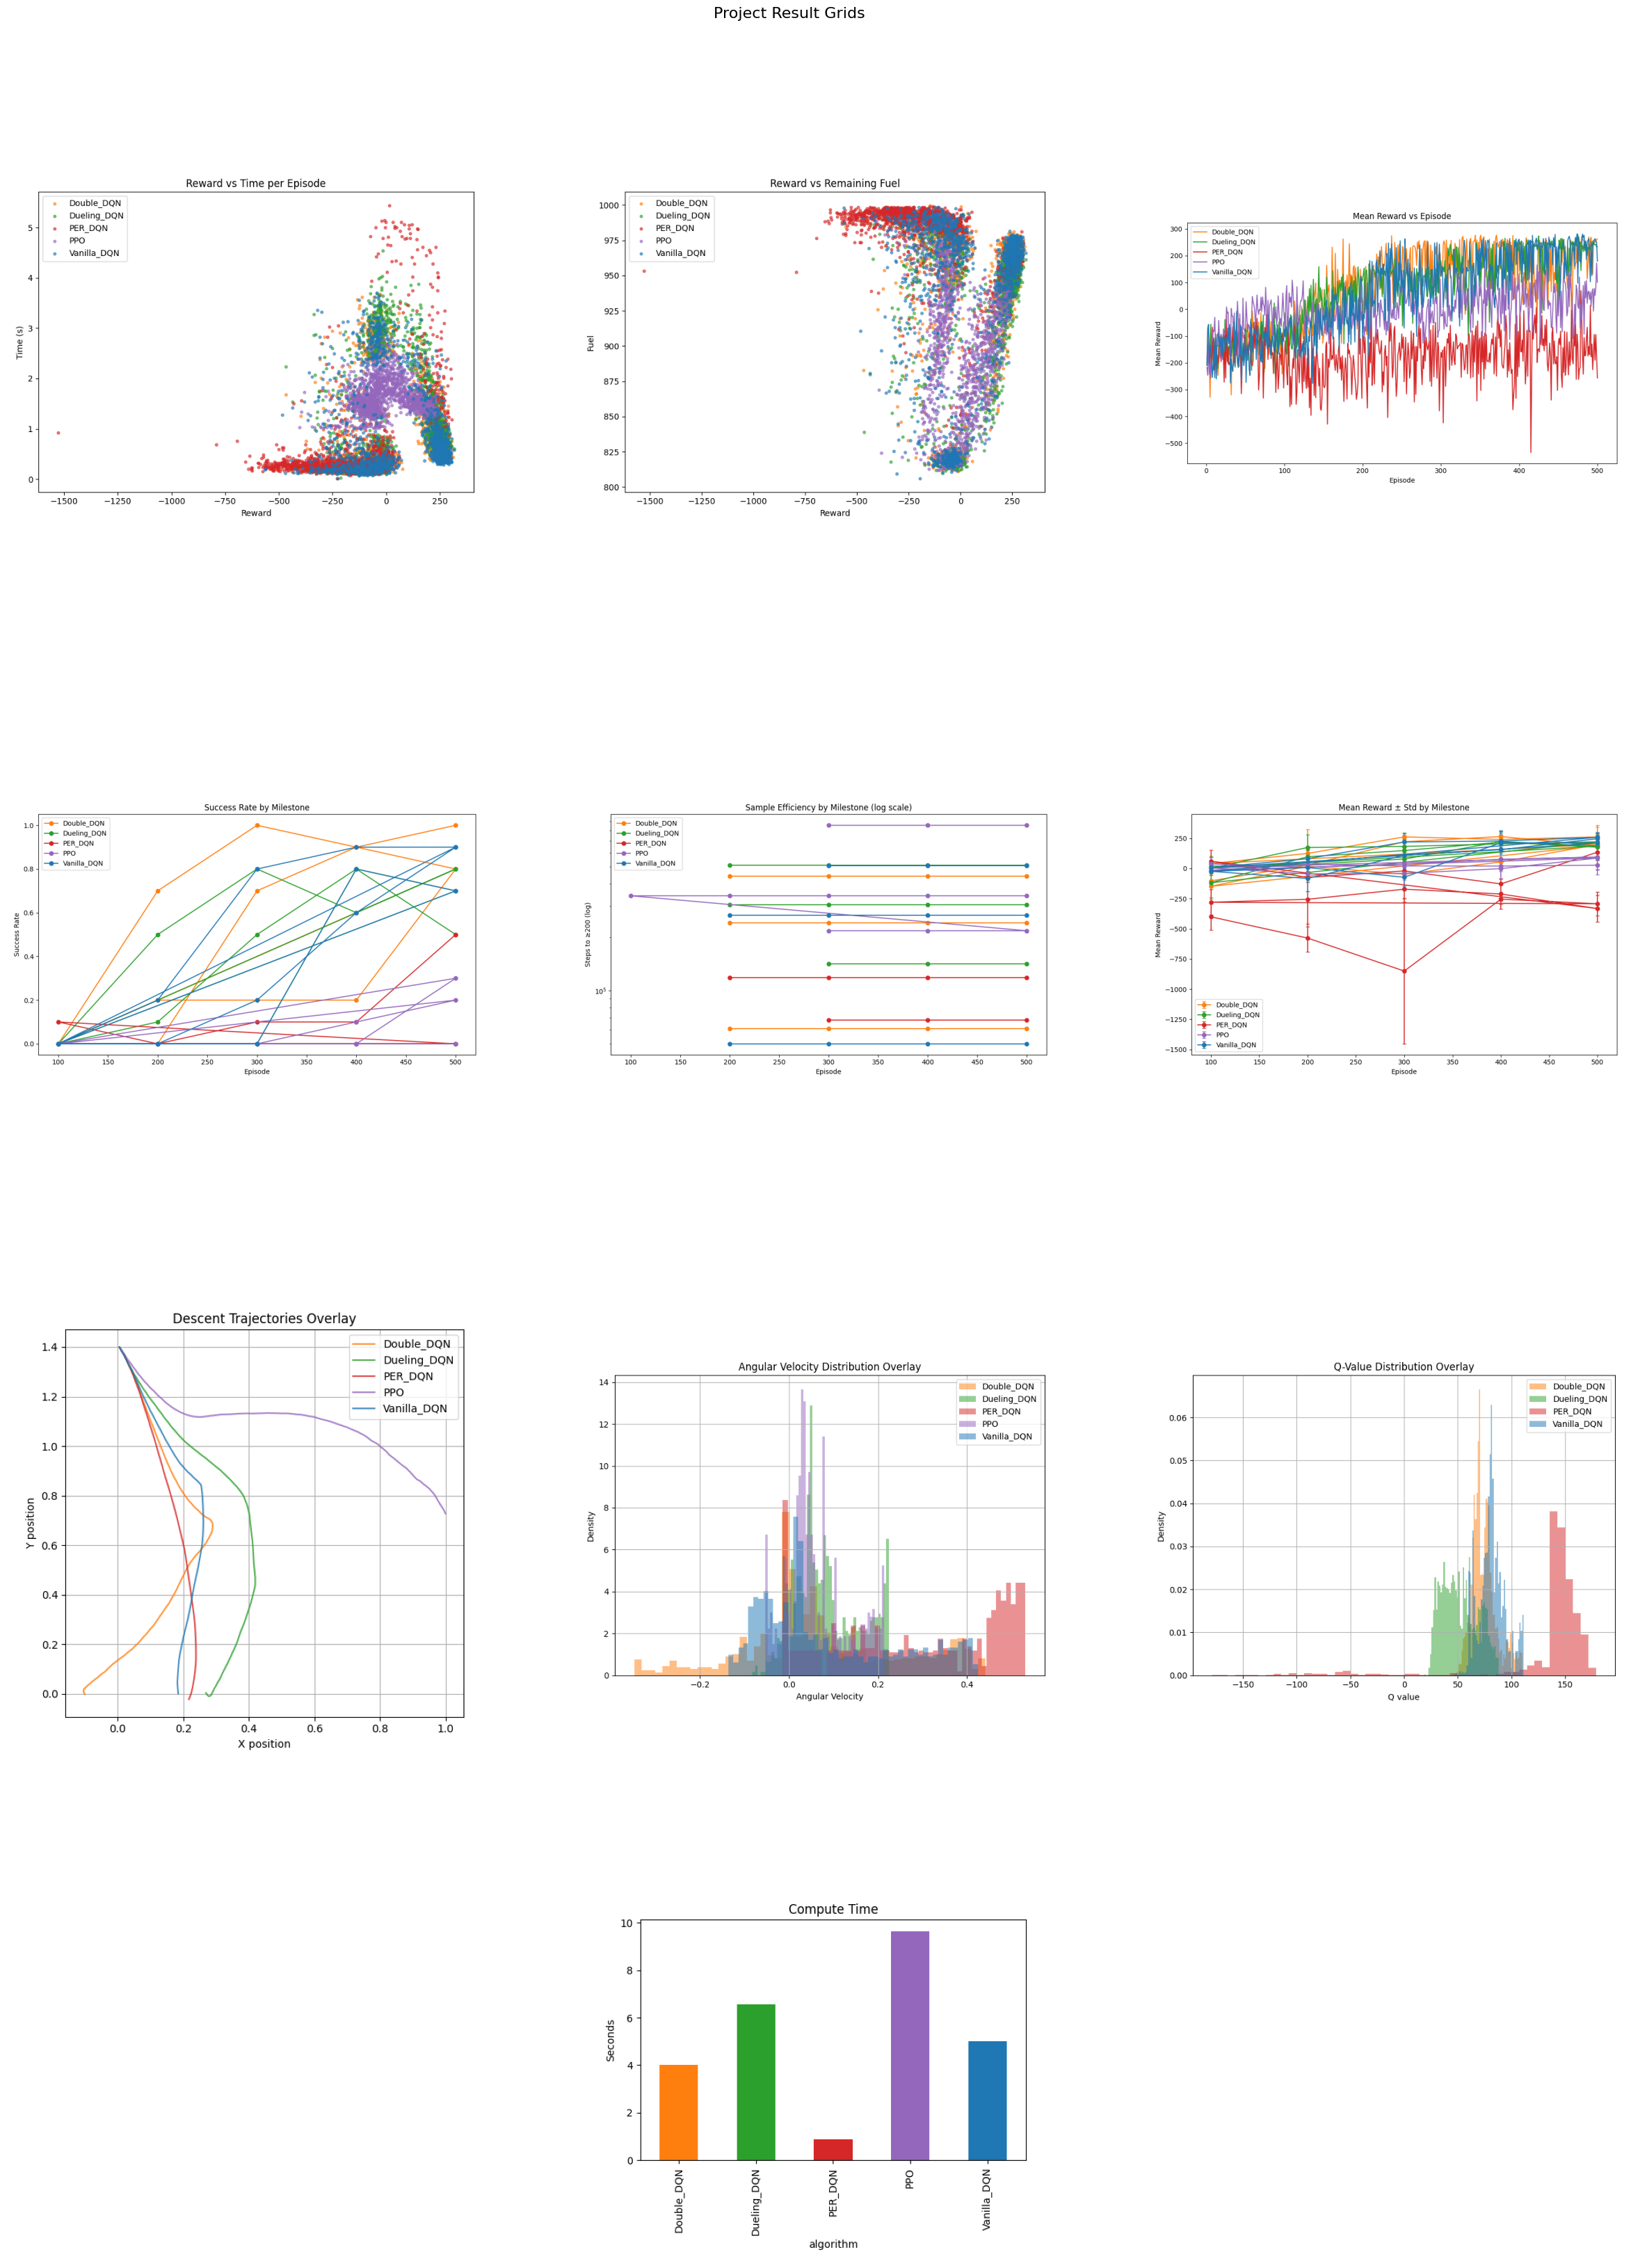

In [22]:
# Cell N: Organise all PNGs into 4 grids (3-up, 3-up, 3-up, 1-up)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import os, pathlib

PLOTS_DIR = pathlib.Path(PLOTS_DIR)   # reuse your variable

# Row-wise filenames (exact order you requested)
row1 = ["reward_vs_time_by_algo.png",
        "reward_vs_fuel_by_algo.png",
        "learning_curve_by_algo.png"]

row2 = ["milestones_success_rate.png",
        "milestones_sample_efficiency_log.png",
        "milestones_reward_errorbar.png"]

row3 = ["trajectory_overlay.png",
        "angular_velocity_overlay.png",
        "q_value_overlay.png"]

row4 = ["compute_cost.png"]   # single wide chart

fig = plt.figure(figsize=(30, 40))
gs  = gridspec.GridSpec(
        nrows=4, ncols=3,
        height_ratios=[1, 1, 1, 0.8],   # last row a bit shorter
        hspace=0.30                     # vertical gap
      )

def add_img(ax, fname):
    img = mpimg.imread(PLOTS_DIR / fname)
    ax.imshow(img)
    ax.axis("off")

# rows 1-3 (1×3 each)
for r, row in enumerate([row1, row2, row3]):
    for c, fname in enumerate(row):
        add_img(fig.add_subplot(gs[r, c]), fname)

# row 4 – span all columns
add_img(fig.add_subplot(gs[3, :]), row4[0])

fig.suptitle("Project Result Grids", fontsize=16, y=0.92)
plt.tight_layout()
plt.show()

In [23]:
!pip install moviepy

In [24]:
# Cell 18b – Convert milestone MP4s to lightweight GIFs
# -----------------------------------------------------
# • Uses moviepy; works with moviepy 1.x, 2.x, and 3.x
# • Creates <algo>_<milestone>_seed0.gif next to each MP4
# • Skips a file if the GIF already exists

from pathlib import Path
import glob, os, sys

# --- moviepy imports (API compatible) ---------------------------------------
from moviepy import VideoFileClip
from moviepy import vfx          # for loop / resize / subclip

BASE_VIDEO_DIR = Path(BASE_VIDEO_DIR)       # your existing global
tl_base        = BASE_VIDEO_DIR / "timeline_comparisons"
algos          = ["Vanilla_DQN", "Double_DQN", "Dueling_DQN", "PER_DQN", "PPO"]
milestones     = [100, 200, 300, 400, 500]
seed           = 0

def make_gif(mp4_path: Path, gif_path: Path):
    """Convert mp4 → gif (≤ ~4 MB) — compatible with moviepy 3.x."""
    clip = VideoFileClip(str(mp4_path))

    # Trim to first 8 s if longer
    if clip.duration and clip.duration > 8:
        try:                                   # moviepy ≤2.x
            clip = clip.subclip(0, 8)
        except AttributeError:                 # moviepy 3.x — use fx
            clip = clip.fx(vfx.subclip, 0, 8)

    # Resize to keep file small
    clip = clip.resize(width=340)

    # Ensure GIF loops forever (moviepy 3.x requires loop fx)
    clip = clip.fx(vfx.loop, n=1)

    clip.write_gif(str(gif_path),
                   fps=12,
                   program="ffmpeg",
                   opt="nq",    # non-quantised → smaller & faster
                   logger=None)
    clip.close()

for algo in algos:
    for m in milestones:
        search_dir = tl_base / f"milestone_{m}_eps" / f"seed{seed}"
        stem       = f"{algo}_milestone_{m}_seed{seed}"
        mp4s       = glob.glob(str(search_dir / f"{stem}*.mp4"))

        if not mp4s:
            continue

        mp4_path = Path(mp4s[0])
        gif_path = mp4_path.with_suffix(".gif")

        if gif_path.exists():
            print(f"skip {gif_path.name}  (already exists)")
            continue

        try:
            make_gif(mp4_path, gif_path)
            print(f"✓ {gif_path.name}")
        except Exception as e:
            print(f"✗ {mp4_path.name} → {e}", file=sys.stderr)

{'video_found': True, 'audio_found': False, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2avc1mp41', 'encoder': 'Lavf61.1.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [600, 400], 'bitrate': 74, 'fps': 50.0, 'codec_name': 'h264', 'profile': '(High)', 'metadata': {'Metadata': '', 'handler_name': 'VideoHandler', 'vendor_id': '[0][0][0][0]', 'encoder': 'Lavc61.3.100 libx264'}}], 'input_number': 0}], 'duration': 10.0, 'bitrate': 79, 'start': 0.0, 'default_video_input_number': 0, 'default_video_stream_number': 0, 'video_codec_name': 'h264', 'video_profile': '(High)', 'video_size': [600, 400], 'video_bitrate': 74, 'video_fps': 50.0, 'video_duration': 10.0, 'video_n_frames': 500}
/usr/local/lib/python3.11/dist-packages/imageio_ffmpeg/binaries/ffmpeg-linux-x86_64-v7.0.2 -i videos/timeline_comparisons/milestone_100_eps/seed0/Vanilla_DQN_milestone_100_seed0-epis

✗ Vanilla_DQN_milestone_100_seed0-episode-0.mp4 → 'VideoFileClip' object has no attribute 'fx'
✗ Vanilla_DQN_milestone_200_seed0-episode-0.mp4 → 'VideoFileClip' object has no attribute 'fx'
✗ Vanilla_DQN_milestone_300_seed0-episode-0.mp4 → 'VideoFileClip' object has no attribute 'resize'
✗ Vanilla_DQN_milestone_400_seed0-episode-0.mp4 → 'VideoFileClip' object has no attribute 'resize'
✗ Vanilla_DQN_milestone_500_seed0-episode-0.mp4 → 'VideoFileClip' object has no attribute 'fx'
✗ Double_DQN_milestone_100_seed0-episode-0.mp4 → 'VideoFileClip' object has no attribute 'resize'
✗ Double_DQN_milestone_200_seed0-episode-0.mp4 → 'VideoFileClip' object has no attribute 'fx'
✗ Double_DQN_milestone_300_seed0-episode-0.mp4 → 'VideoFileClip' object has no attribute 'resize'
✗ Double_DQN_milestone_400_seed0-episode-0.mp4 → 'VideoFileClip' object has no attribute 'resize'
✗ Double_DQN_milestone_500_seed0-episode-0.mp4 → 'VideoFileClip' object has no attribute 'resize'


{'video_found': True, 'audio_found': False, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2avc1mp41', 'encoder': 'Lavf61.1.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [600, 400], 'bitrate': 74, 'fps': 50.0, 'codec_name': 'h264', 'profile': '(High)', 'metadata': {'Metadata': '', 'handler_name': 'VideoHandler', 'vendor_id': '[0][0][0][0]', 'encoder': 'Lavc61.3.100 libx264'}}], 'input_number': 0}], 'duration': 10.0, 'bitrate': 80, 'start': 0.0, 'default_video_input_number': 0, 'default_video_stream_number': 0, 'video_codec_name': 'h264', 'video_profile': '(High)', 'video_size': [600, 400], 'video_bitrate': 74, 'video_fps': 50.0, 'video_duration': 10.0, 'video_n_frames': 500}
/usr/local/lib/python3.11/dist-packages/imageio_ffmpeg/binaries/ffmpeg-linux-x86_64-v7.0.2 -i videos/timeline_comparisons/milestone_100_eps/seed0/Dueling_DQN_milestone_100_seed0-epis

✗ Dueling_DQN_milestone_100_seed0-episode-0.mp4 → 'VideoFileClip' object has no attribute 'fx'
✗ Dueling_DQN_milestone_200_seed0-episode-0.mp4 → 'VideoFileClip' object has no attribute 'fx'
✗ Dueling_DQN_milestone_300_seed0-episode-0.mp4 → 'VideoFileClip' object has no attribute 'fx'
✗ Dueling_DQN_milestone_400_seed0-episode-0.mp4 → 'VideoFileClip' object has no attribute 'fx'
✗ Dueling_DQN_milestone_500_seed0-episode-0.mp4 → 'VideoFileClip' object has no attribute 'resize'
✗ PER_DQN_milestone_100_seed0-episode-0.mp4 → 'VideoFileClip' object has no attribute 'resize'
✗ PER_DQN_milestone_200_seed0-episode-0.mp4 → 'VideoFileClip' object has no attribute 'resize'
✗ PER_DQN_milestone_300_seed0-episode-0.mp4 → 'VideoFileClip' object has no attribute 'resize'
✗ PER_DQN_milestone_400_seed0-episode-0.mp4 → 'VideoFileClip' object has no attribute 'resize'
✗ PER_DQN_milestone_500_seed0-episode-0.mp4 → 'VideoFileClip' object has no attribute 'resize'


{'video_found': True, 'audio_found': False, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2avc1mp41', 'encoder': 'Lavf61.1.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [600, 400], 'bitrate': 63, 'fps': 50.0, 'codec_name': 'h264', 'profile': '(High)', 'metadata': {'Metadata': '', 'handler_name': 'VideoHandler', 'vendor_id': '[0][0][0][0]', 'encoder': 'Lavc61.3.100 libx264'}}], 'input_number': 0}], 'duration': 10.0, 'bitrate': 69, 'start': 0.0, 'default_video_input_number': 0, 'default_video_stream_number': 0, 'video_codec_name': 'h264', 'video_profile': '(High)', 'video_size': [600, 400], 'video_bitrate': 63, 'video_fps': 50.0, 'video_duration': 10.0, 'video_n_frames': 500}
/usr/local/lib/python3.11/dist-packages/imageio_ffmpeg/binaries/ffmpeg-linux-x86_64-v7.0.2 -i videos/timeline_comparisons/milestone_100_eps/seed0/PPO_milestone_100_seed0-episode-0.mp

✗ PPO_milestone_100_seed0-episode-0.mp4 → 'VideoFileClip' object has no attribute 'fx'
✗ PPO_milestone_200_seed0-episode-0.mp4 → 'VideoFileClip' object has no attribute 'fx'


{'video_found': True, 'audio_found': False, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2avc1mp41', 'encoder': 'Lavf61.1.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [600, 400], 'bitrate': 65, 'fps': 50.0, 'codec_name': 'h264', 'profile': '(High)', 'metadata': {'Metadata': '', 'handler_name': 'VideoHandler', 'vendor_id': '[0][0][0][0]', 'encoder': 'Lavc61.3.100 libx264'}}], 'input_number': 0}], 'duration': 10.0, 'bitrate': 70, 'start': 0.0, 'default_video_input_number': 0, 'default_video_stream_number': 0, 'video_codec_name': 'h264', 'video_profile': '(High)', 'video_size': [600, 400], 'video_bitrate': 65, 'video_fps': 50.0, 'video_duration': 10.0, 'video_n_frames': 500}
/usr/local/lib/python3.11/dist-packages/imageio_ffmpeg/binaries/ffmpeg-linux-x86_64-v7.0.2 -i videos/timeline_comparisons/milestone_300_eps/seed0/PPO_milestone_300_seed0-episode-0.mp

✗ PPO_milestone_300_seed0-episode-0.mp4 → 'VideoFileClip' object has no attribute 'fx'
✗ PPO_milestone_400_seed0-episode-0.mp4 → 'VideoFileClip' object has no attribute 'fx'
✗ PPO_milestone_500_seed0-episode-0.mp4 → 'VideoFileClip' object has no attribute 'fx'


In [25]:
# Cell 19 – 5 × 5 Milestone Video/GIF Gallery
# -------------------------------------------
from IPython.display import HTML, Video, display
from pathlib import Path
import glob, base64, mimetypes

BASE_VIDEO_DIR = Path(BASE_VIDEO_DIR)
tl_base        = BASE_VIDEO_DIR / "timeline_comparisons"

algos      = ["Vanilla_DQN", "Double_DQN", "Dueling_DQN", "PER_DQN", "PPO"]
milestones = [100, 200, 300, 400, 500]
seed       = 0                                  # gallery for seed0 only

# ---------------------------------------------------------------------------
def locate_clip(algo:str, m:int) -> tuple[Path|None, str|None]:
    """Return (Path, 'gif' | 'mp4' | None)."""
    dir_ = tl_base / f"milestone_{m}_eps" / f"seed{seed}"
    stem = f"{algo}_milestone_{m}_seed{seed}"

    gif = next((Path(p) for p in glob.glob(str(dir_ / f"{stem}*.gif"))), None)
    if gif:
        return gif, "gif"

    mp4 = next((Path(p) for p in glob.glob(str(dir_ / f"{stem}*.mp4"))), None)
    return (mp4, "mp4") if mp4 else (None, None)

def embed_base64(path:Path, width:int=220) -> str:
    data = path.read_bytes()
    b64  = base64.b64encode(data).decode()
    mime = mimetypes.guess_type(path.name)[0] or "video/mp4"
    return (f"<video width='{width}' controls muted>"
            f"<source src='data:{mime};base64,{b64}'></video>")

def cell_html(path:Path|None, kind:str|None) -> str:
    if path is None:
        return "<span style='color:#c33;font-weight:600'>n/a</span>"

    # If we have a GIF → embed <img>
    if kind == "gif":
        return f"<img src='{path.as_posix()}' width='220'/>"

    # Else MP4
    if path.stat().st_size <= 4_000_000:   # ≤4 MB → base64 inline
        return embed_base64(path)
    else:                                  # large → external tag
        return (f"<video src='{path.as_posix()}' width='220' "
                "controls muted preload='metadata'></video>")

# -------- build HTML table --------------------------------------------------
html  = "<table style='border-collapse:collapse;font-size:0.85em'>"
html += "<tr><th></th>" + "".join(f"<th>{a}</th>" for a in algos) + "</tr>"

for m in milestones:
    html += f"<tr><th style='text-align:right'>{m}</th>"
    for algo in algos:
        p, kind = locate_clip(algo, m)
        html   += f"<td style='padding:4px'>{cell_html(p, kind)}</td>"
    html += "</tr>"

html += "</table>"
display(HTML(html))

#Documentation

##LunarLander-v3 Benchmark — DQN Family vs PPO

This repository contains:

| Folder | Purpose |
|--------|---------|
| `notebooks/` | **`lunar_lander_benchmark.ipynb`** – executed notebook with code, plots, and milestone videos/GIFs. |
| `videos/`    | Raw MP4 clips saved during milestone evaluation. |
| `gifs/`      | Lightweight GIF previews generated from the MP4s (render inline on GitHub). |
| `plots/`     | All result charts saved as PNGs (also embedded inline in the notebook). |
| `models/`    | Final trained model checkpoints (DQN `.pth`, PPO `.zip`). |

> **Tip:** Open the notebook in **Google Colab** or **nbviewer** for full inline video playback.

---

## 🔧  Setup

```bash
git clone https://github.com/your-username/rl-carracing-dqn-vs-ppo.git
cd rl-carracing-dqn-vs-ppo
pip install -r requirements.txt

Python ≥ 3.9, CUDA optional.
Key packages: stable-baselines3, gymnasium[box2d], moviepy, matplotlib, pandas.

⸻

▶️  Quick start (Colab)
	1.	Open notebooks/lunar_lander_benchmark.ipynb in Colab.
	2.	Runtime → Run all (≈ 15 min on a free GPU).
	3.	Scroll to:
	•	Section 2 – Training logs
	•	Section 3 – Result grids (plots)
	•	Section 4 – 5×5 milestone video/GIF gallery

All plots/GIFs are regenerated automatically; MP4 clips are produced every
MILESTONES = [100,200,300,400,500] episodes for seed 0.

⸻

🏗️  Notebook structure

Section	Code cells	What it does
1  Imports & globals	Cell 0	Sets hyper-params, seeds, color palette.
2  Training	Cell 13	train_and_snapshot() trains Vanilla DQN, Double DQN, Dueling DQN, PER-DQN, PPO; logs per-episode CSVs, saves milestone videos and model checkpoints.
3  Post-training plots	Cell 18	Reads CSVs → writes PNGs + displays them inline; covers learning curves, milestone trends, overlays.
4  GIF conversion	Cell 18b	Converts each milestone MP4 to a small GIF (moviepy).
5  Video/GIF gallery	Cell 19	Builds 5 × 5 HTML table (rows = milestones, cols = algos); embeds GIF if present, else MP4 (≤ 4 MB base-64, otherwise thumbnail).
6  Discussion	Cell 20	Brief conclusions + next-step suggestions.



⸻

🔄  Reproduce your own run

python scripts/run_benchmark.py --env LunarLander-v3 \
                                --episodes 500 \
                                --seeds 0 1 2

The script is a thin wrapper around the same functions used in the notebook; it writes logs, plots, and videos to the same folders.

⸻

📊  Evaluation metrics
	•	Reward (mean ± std) per episode and milestone
	•	Success rate (reward ≥ 200) per milestone
	•	Sample efficiency = steps to first success
	•	Training stability = rolling σ₅₀(reward)
	•	Compute cost = mean wall-clock seconds per algorithm

See plots/ or the “Result grids” section in the notebook for visuals.

⸻

❓  FAQ
	•	Why don’t MP4s autoplay on GitHub?
GitHub’s viewer blocks inline MP4. GIF previews are provided; open the notebook in Colab/nbviewer for full playback.
	•	How do I change milestones?
Edit MILESTONES at the top of the notebook and rerun Cells 13, 18, 18b, 19.

⸻

© 2025 NC — MIT License

---

## 📝 2. Inline code-doc suggestions

Add these **doc-strings** at the top of each major function / cell (only one example shown; copy the pattern).

```python
# Cell 13  ──────────────────────────────────────────────────────────────
def train_and_snapshot(name: str, agent_ctor, is_ppo: bool):
    """
    Train an RL agent and log everything needed for the final report.

    Parameters
    ----------
    name : str
        Human-readable algorithm label (e.g. "Vanilla_DQN").
    agent_ctor : Callable
        Factory that returns an *untrained* agent instance.
    is_ppo : bool
        Flag because SB3-PPO API differences (VecEnv, .learn, .predict).

    Side-effects
    ------------
    • Appends per-episode rows to `master_full_training.csv`
    • Appends milestone rows to `master_milestone_metrics.csv`
    • Saves model checkpoints under <BASE_LOG_DIR>/<name>/
    • Records a single MP4 per milestone & seed
    • Returns the trained agent instance
    """

At the top of Cell 18:

# Cell 18  — Post-Training Evaluation & Plotting
"""
Reads the two master CSV logs and generates all required plots:

Row 1 – learning curves  
Row 2 – milestone metrics  
Row 3 – distribution overlays  
Row 4 – compute-cost bar

Each figure is saved to plots/ and also displayed inline via plt.show().
"""

At the top of Cell 18b:

# Cell 18b — MP4 → GIF batch conversion
"""
Converts every milestone MP4 (seed 0) to a small GIF for GitHub-friendly
inline animation. Skips clips that already have a .gif twin.

Requires `moviepy>=1.0`. Typical output size: 2-4 MB per GIF.
"""

At the top of Cell 19:

# Cell 19 — 5 × 5 Milestone Video/GIF Gallery
"""
Builds an HTML table where each row = milestone (100-500), each column =
algorithm. For each cell:

1. If a GIF exists → <img> embed (animates everywhere).  
2. Else if MP4 ≤ 4 MB → base-64 <video> embed (plays inline).  
3. Else            → external <video> tag (click-to-play on GitHub).

Displayed via `IPython.display.HTML`; no disk writes.
"""



